# Laboratorio 2 Fundamentos de Aprendizaje Profundo
Temática: Comportamiento y predicción del clima

Nombre: Antonina Arriagada

### 1. Definiciones e importación librerias

In [6]:
import torch
import xarray as xr
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, TensorDataset
import dask
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim

#### 1.1 Descarga del Dataset

Descarga de ERA5 desde 1959 a 2022 cada 6 horas. Resolución de 1440x721

In [7]:
dataset_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
ds = xr.open_zarr(dataset_path)
print(ds)

<xarray.Dataset> Size: 41TB
Dimensions:                                           (time: 92044,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 736kB ...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 382GB ...
    10m_v_component_of_wind                           (time, latitude, longitude) float32 382GB ...
    10m_wind_speed                                    (time, latitude, longitude) float32 382GB ...
    2m_temperature           

#### 1.2 Análisis Exploratorio

In [ ]:
lat_min = ds['latitude'].min().values
lat_max = ds['latitude'].max().values
lon_min = ds['longitude'].min().values
lon_max = ds['longitude'].max().values

print(f"Rango de latitud en el dataset: {lat_min} a {lat_max}")
print(f"Rango de longitud en el dataset: {lon_min} a {lon_max}")

Rango de latitud en el dataset: -90.0 a 90.0
Rango de longitud en el dataset: 0.0 a 359.75


In [ ]:
chile_ds = ds.sel(
    latitude=slice(-17.0, -56.0), 
    longitude=slice(280.0, 310.0) 
)
print(chile_ds)

<xarray.Dataset> Size: 755GB
Dimensions:                                           (time: 92044,
                                                       latitude: 157,
                                                       longitude: 121, level: 13)
Coordinates:
  * latitude                                          (latitude) float32 628B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 484B ...
  * time                                              (time) datetime64[ns] 736kB ...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float3

In [ ]:
lat_min = chile_ds['latitude'].min().values
lat_max = chile_ds['latitude'].max().values
lon_min = chile_ds['longitude'].min().values
lon_max = chile_ds['longitude'].max().values

print(f"Rango de latitud seleccionado: {lat_min} a {lat_max}")
print(f"Rango de longitud seleccionado: {lon_min} a {lon_max}")

Rango de latitud seleccionado: -56.0 a -17.0
Rango de longitud seleccionado: 280.0 a 310.0


In [ ]:
for var in chile_ds.data_vars:
    print(f"{var}: {chile_ds[var].shape}")

10m_u_component_of_wind: (92044, 157, 121)
10m_v_component_of_wind: (92044, 157, 121)
10m_wind_speed: (92044, 157, 121)
2m_temperature: (92044, 157, 121)
angle_of_sub_gridscale_orography: (157, 121)
anisotropy_of_sub_gridscale_orography: (157, 121)
geopotential: (92044, 13, 157, 121)
geopotential_at_surface: (157, 121)
high_vegetation_cover: (157, 121)
lake_cover: (157, 121)
lake_depth: (157, 121)
land_sea_mask: (157, 121)
low_vegetation_cover: (157, 121)
mean_sea_level_pressure: (92044, 157, 121)
sea_ice_cover: (92044, 157, 121)
sea_surface_temperature: (92044, 157, 121)
slope_of_sub_gridscale_orography: (157, 121)
soil_type: (157, 121)
specific_humidity: (92044, 13, 157, 121)
standard_deviation_of_filtered_subgrid_orography: (157, 121)
standard_deviation_of_orography: (157, 121)
surface_pressure: (92044, 157, 121)
temperature: (92044, 13, 157, 121)
toa_incident_solar_radiation: (92044, 157, 121)
toa_incident_solar_radiation_12hr: (92044, 157, 121)
toa_incident_solar_radiation_24hr: (

Selección de dirección: Cono sur Sudamérica.

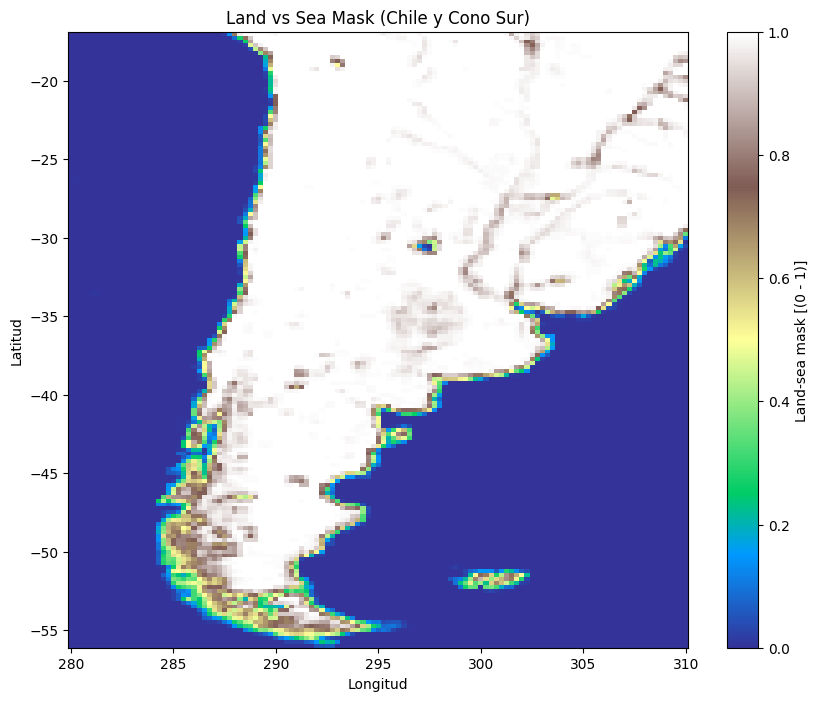

In [ ]:
land_sea = chile_ds['land_sea_mask']
plt.figure(figsize=(10, 8))
land_sea.plot(cmap="terrain", add_colorbar=True)
plt.title("Land vs Sea Mask (Chile y Cono Sur)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Gráfico para observar el comportamiento de las componentes del viento sobre la temperatura

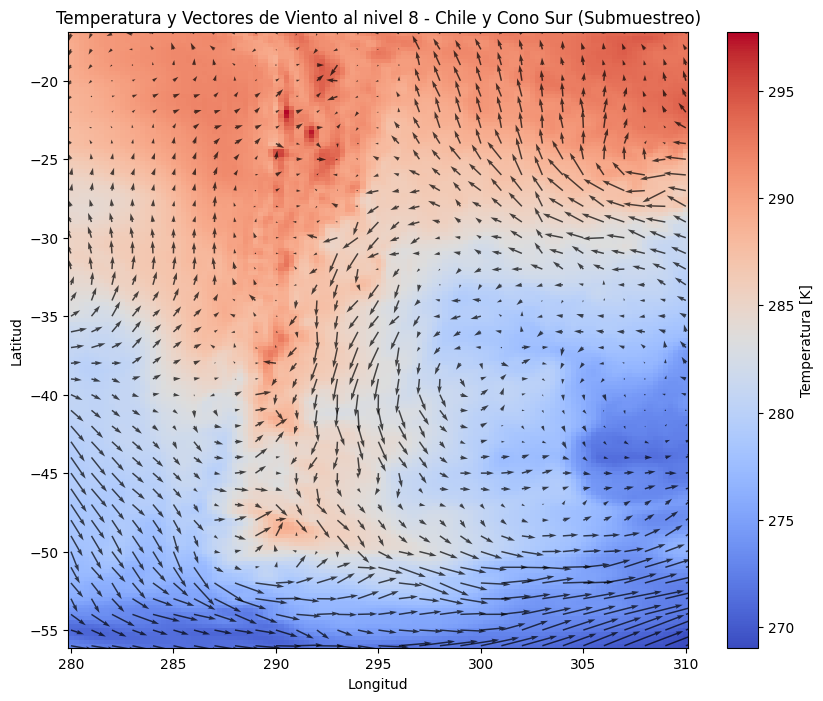

In [ ]:
temp = chile_ds['temperature'].isel(time=0, level=10)
u_wind = chile_ds['u_component_of_wind'].isel(time=0, level=10)
v_wind = chile_ds['v_component_of_wind'].isel(time=0, level=10)

lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))

plt.pcolormesh(lon, lat, temp, cmap="coolwarm", shading="auto")
plt.colorbar(label="Temperatura [K]")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=300, color='black', alpha=0.7)
plt.title("Temperatura y Vectores de Viento al nivel 8 - Chile y Cono Sur (Submuestreo)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Temperatura en el nivel 10

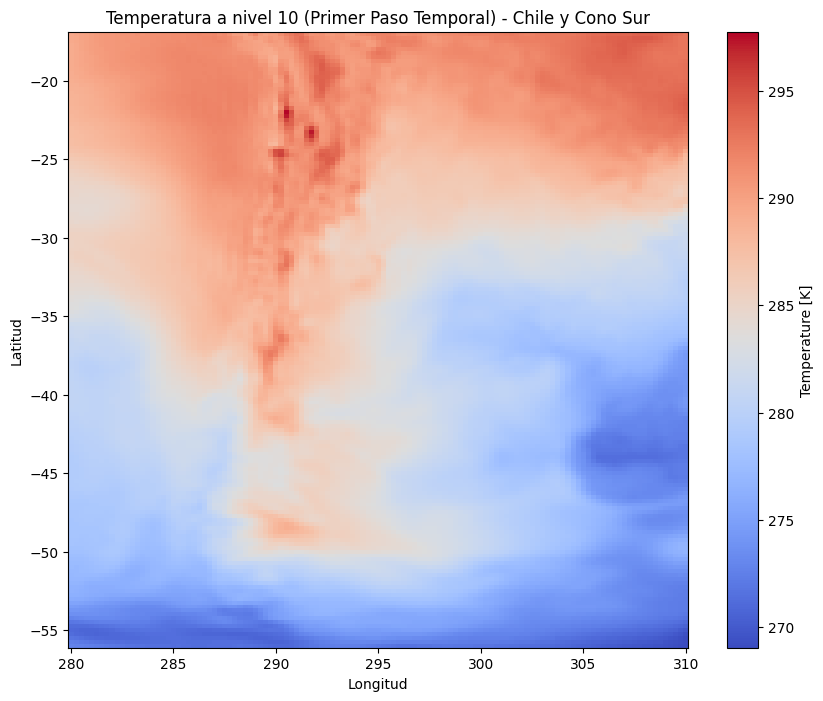

In [ ]:
temperature = chile_ds['temperature'].isel(time=0, level=10)
plt.figure(figsize=(10, 8))
temperature.plot(cmap="coolwarm", add_colorbar=True)
plt.title("Temperatura a nivel 10 (Primer Paso Temporal) - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Gráfico para observar la relación entre la humedad específica, temperatura y viento.

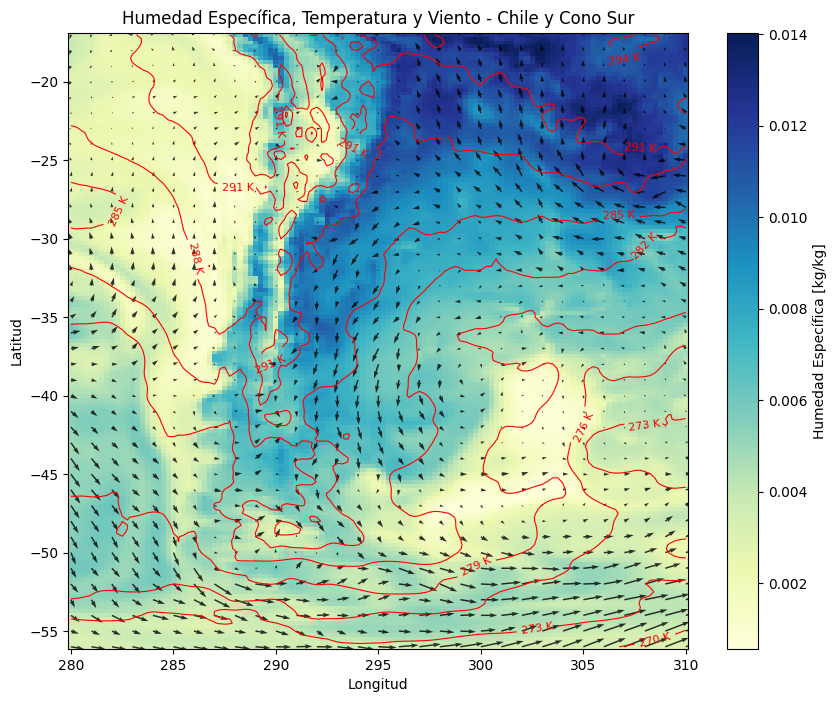

In [ ]:
temperature = chile_ds['temperature'].isel(time=0, level=10)
specific_humidity = chile_ds['specific_humidity'].isel(time=0, level=10) 
u_wind = chile_ds['u_component_of_wind'].isel(time=0, level=10)
v_wind = chile_ds['v_component_of_wind'].isel(time=0, level=10)
lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))
plt.pcolormesh(lon, lat, specific_humidity, cmap="YlGnBu", shading="auto")
plt.colorbar(label="Humedad Específica [kg/kg]")
contour = plt.contour(lon, lat, temperature, levels=10, colors='red', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt="%.0f K")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=500, color='black', alpha=0.8)
plt.title("Humedad Específica, Temperatura y Viento - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Gráfico para observar la temperatura a 2m de la superficie

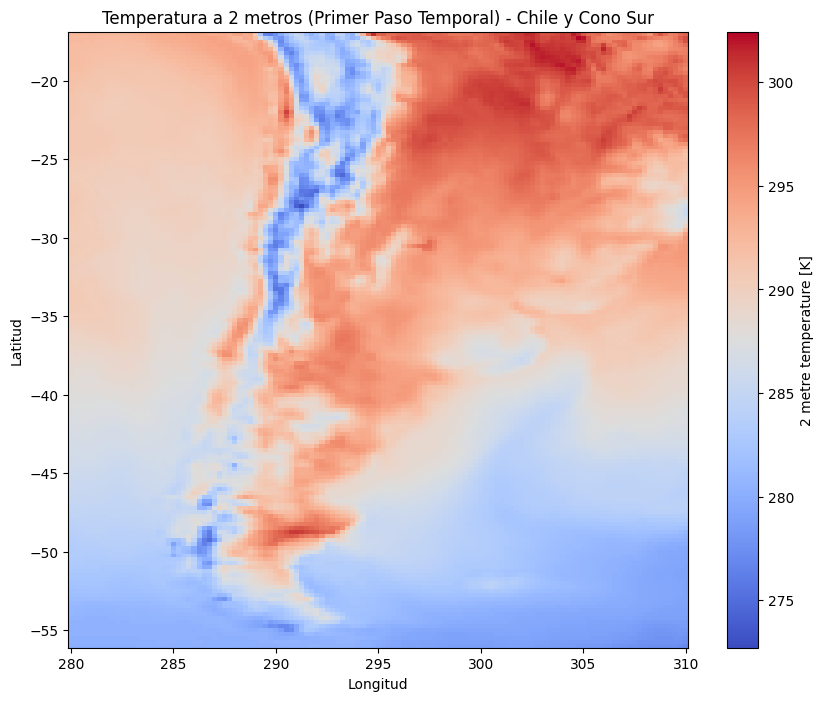

In [ ]:
temp_2m = chile_ds['2m_temperature'].isel(time=0)
plt.figure(figsize=(10, 8))
temp_2m.plot(cmap="coolwarm", add_colorbar=True)
plt.title("Temperatura a 2 metros (Primer Paso Temporal) - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Componientes del viento a 10 metros

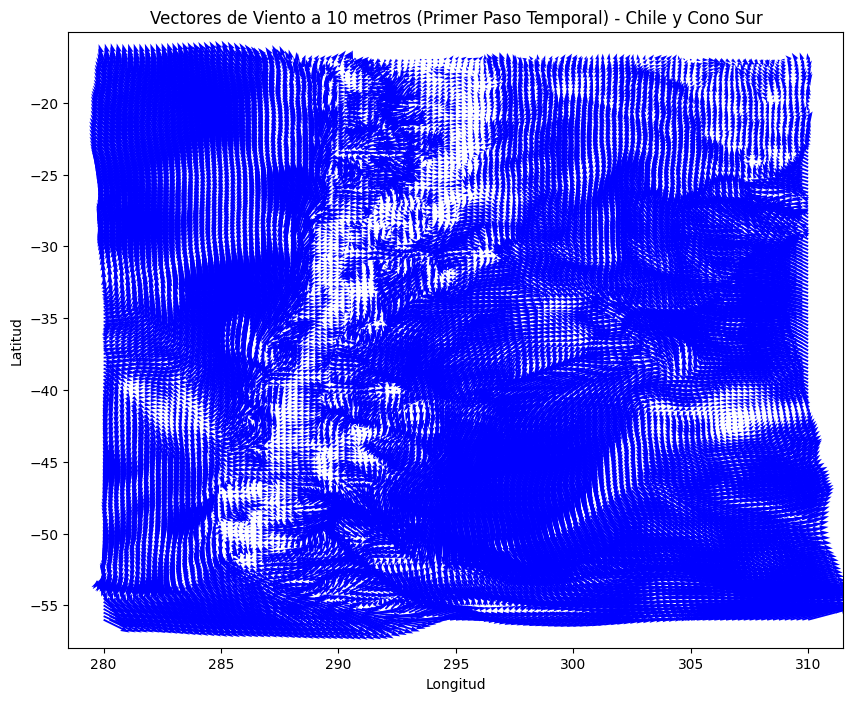

In [ ]:
u_wind = chile_ds['10m_u_component_of_wind'].isel(time=0)
v_wind = chile_ds['10m_v_component_of_wind'].isel(time=0)
lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])
plt.figure(figsize=(10, 8))
plt.quiver(lon, lat, u_wind, v_wind, scale=200, color='blue')
plt.title("Vectores de Viento a 10 metros (Primer Paso Temporal) - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


Gráfico para observar la relación entre las componentes del viento sobre la temperatura a 2 y 10 metros respectivamente. El viento debería converger hacia las zonas azules.

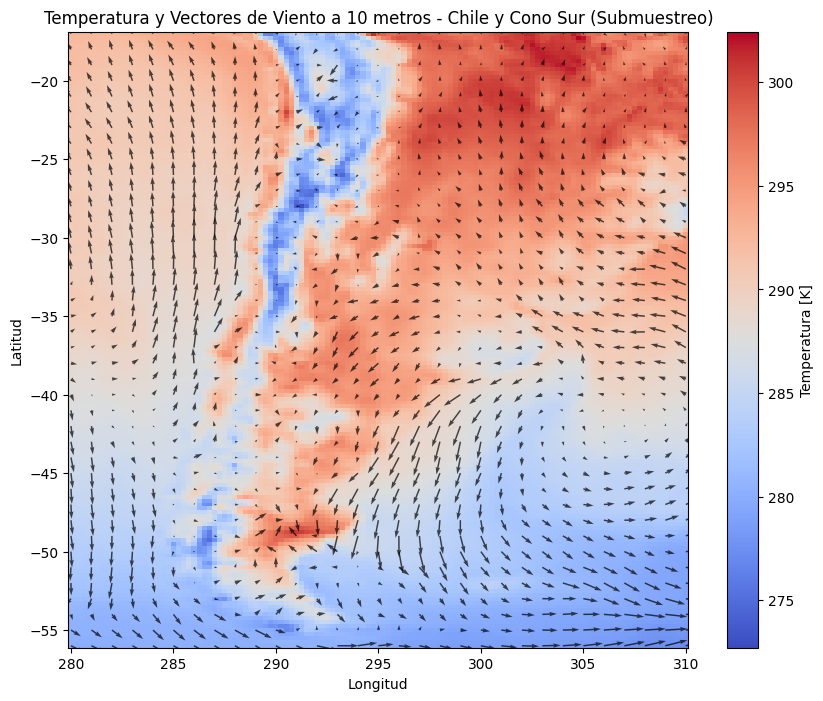

In [ ]:
temp_2m = chile_ds['2m_temperature'].isel(time=0)
u_wind = chile_ds['10m_u_component_of_wind'].isel(time=0)
v_wind = chile_ds['10m_v_component_of_wind'].isel(time=0)

lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))

plt.pcolormesh(lon, lat, temp_2m, cmap="coolwarm", shading="auto")
plt.colorbar(label="Temperatura [K]")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=300, color='black', alpha=0.7)
plt.title("Temperatura y Vectores de Viento a 10 metros - Chile y Cono Sur (Submuestreo)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Gráfico para observar la presión de la superficie y la relación con las vectores del viento a 10 metros.

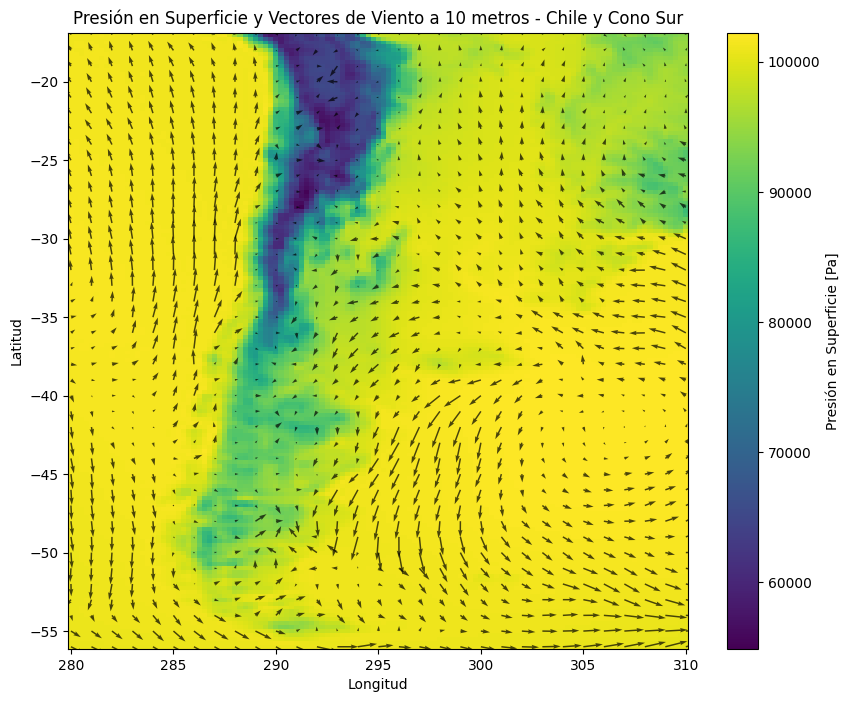

In [ ]:
surface_pressure = chile_ds['surface_pressure'].isel(time=0)
u_wind = chile_ds['10m_u_component_of_wind'].isel(time=0)
v_wind = chile_ds['10m_v_component_of_wind'].isel(time=0)
lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])
step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))
plt.pcolormesh(lon, lat, surface_pressure, cmap="viridis", shading="auto")
plt.colorbar(label="Presión en Superficie [Pa]")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=300, color='black', alpha=0.7)
plt.title("Presión en Superficie y Vectores de Viento a 10 metros - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Gráfico para observar la humedad específica en el nivel 0 con las variables anteriormente mencionadas, componenentes de viento a nivel 0 y temperatura a 2m.

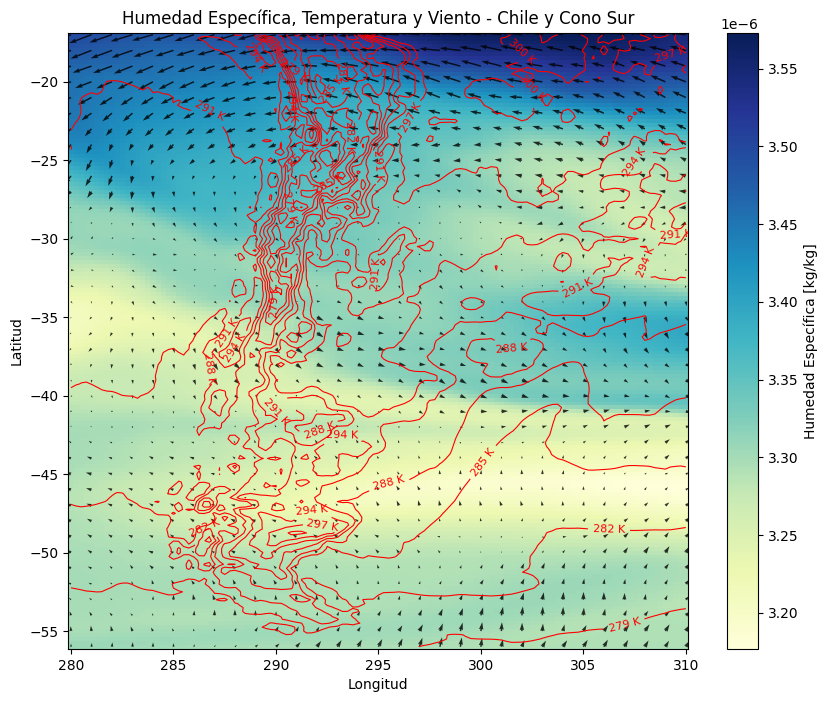

In [ ]:
temp_2m = chile_ds['2m_temperature'].isel(time=0)
specific_humidity = chile_ds['specific_humidity'].isel(time=0, level=0)  # Humedad específica en el mismo nivel
u_wind = chile_ds['u_component_of_wind'].isel(time=0, level=0)
v_wind = chile_ds['v_component_of_wind'].isel(time=0, level=0)
lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))
plt.pcolormesh(lon, lat, specific_humidity, cmap="YlGnBu", shading="auto")
plt.colorbar(label="Humedad Específica [kg/kg]")
contour = plt.contour(lon, lat, temp_2m, levels=10, colors='red', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt="%.0f K")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=500, color='black', alpha=0.8)
plt.title("Humedad Específica, Temperatura y Viento - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Geopotencial en el nivel 10 igual que temperatura, humedad especifica y comp de vientos.

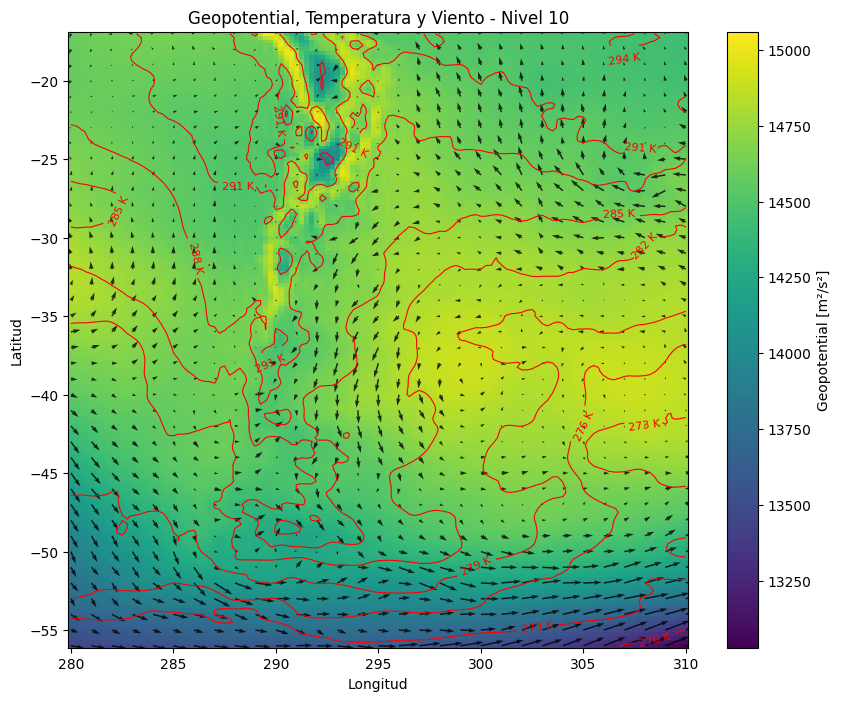

In [ ]:
geopotential = chile_ds['geopotential'].isel(time=0, level=10)  # Geopotential en nivel 10
temperature = chile_ds['temperature'].isel(time=0, level=10)
specific_humidity = chile_ds['specific_humidity'].isel(time=0, level=10)
u_wind = chile_ds['u_component_of_wind'].isel(time=0, level=10)
v_wind = chile_ds['v_component_of_wind'].isel(time=0, level=10)

lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))
plt.pcolormesh(lon, lat, geopotential, cmap="viridis", shading="auto")
plt.colorbar(label="Geopotential [m²/s²]")
contour = plt.contour(lon, lat, temperature, levels=10, colors='red', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt="%.0f K")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=500, color='black', alpha=0.8)
plt.title("Geopotential, Temperatura y Viento - Nivel 10")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


Selección de subdataset y variables

In [15]:
chile_ds = ds.sel(
    latitude=slice(-17.0, -56.0), 
    longitude=slice(280.0, 310.0) 
)
variables = ['u_component_of_wind', 'v_component_of_wind', 
             'temperature', 'specific_humidity', 'geopotential']
subset_selected_ch = chile_ds[variables].isel(level=10)
ds = subset_selected_ch.sel(time=slice("2010-01-01", "2010-01-31"))
print(ds)

<xarray.Dataset> Size: 47MB
Dimensions:              (time: 124, latitude: 157, longitude: 121)
Coordinates:
  * latitude             (latitude) float32 628B -17.0 -17.25 ... -55.75 -56.0
    level                int64 8B 850
  * longitude            (longitude) float32 484B 280.0 280.2 ... 309.8 310.0
  * time                 (time) datetime64[ns] 992B 2010-01-01 ... 2010-01-31...
Data variables:
    u_component_of_wind  (time, latitude, longitude) float32 9MB ...
    v_component_of_wind  (time, latitude, longitude) float32 9MB ...
    temperature          (time, latitude, longitude) float32 9MB ...
    specific_humidity    (time, latitude, longitude) float32 9MB ...
    geopotential         (time, latitude, longitude) float32 9MB ...


In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    subset_selected_ch.to_zarr("dataset/chile_2010_january.zarr", consolidated=True)

[########################################] | 100% Completed | 23m 57s


In [6]:
ds = xr.open_zarr("dataset/chile_2010_january.zarr")
print(ds)

<xarray.Dataset> Size: 47MB
Dimensions:              (time: 124, latitude: 157, longitude: 121)
Coordinates:
  * latitude             (latitude) float32 628B -17.0 -17.25 ... -55.75 -56.0
    level                int64 8B ...
  * longitude            (longitude) float32 484B 280.0 280.2 ... 309.8 310.0
  * time                 (time) datetime64[ns] 992B 2010-01-01 ... 2010-01-31...
Data variables:
    geopotential         (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    specific_humidity    (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    temperature          (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    u_component_of_wind  (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    v_component_of_wind  (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>


distribución de las variables

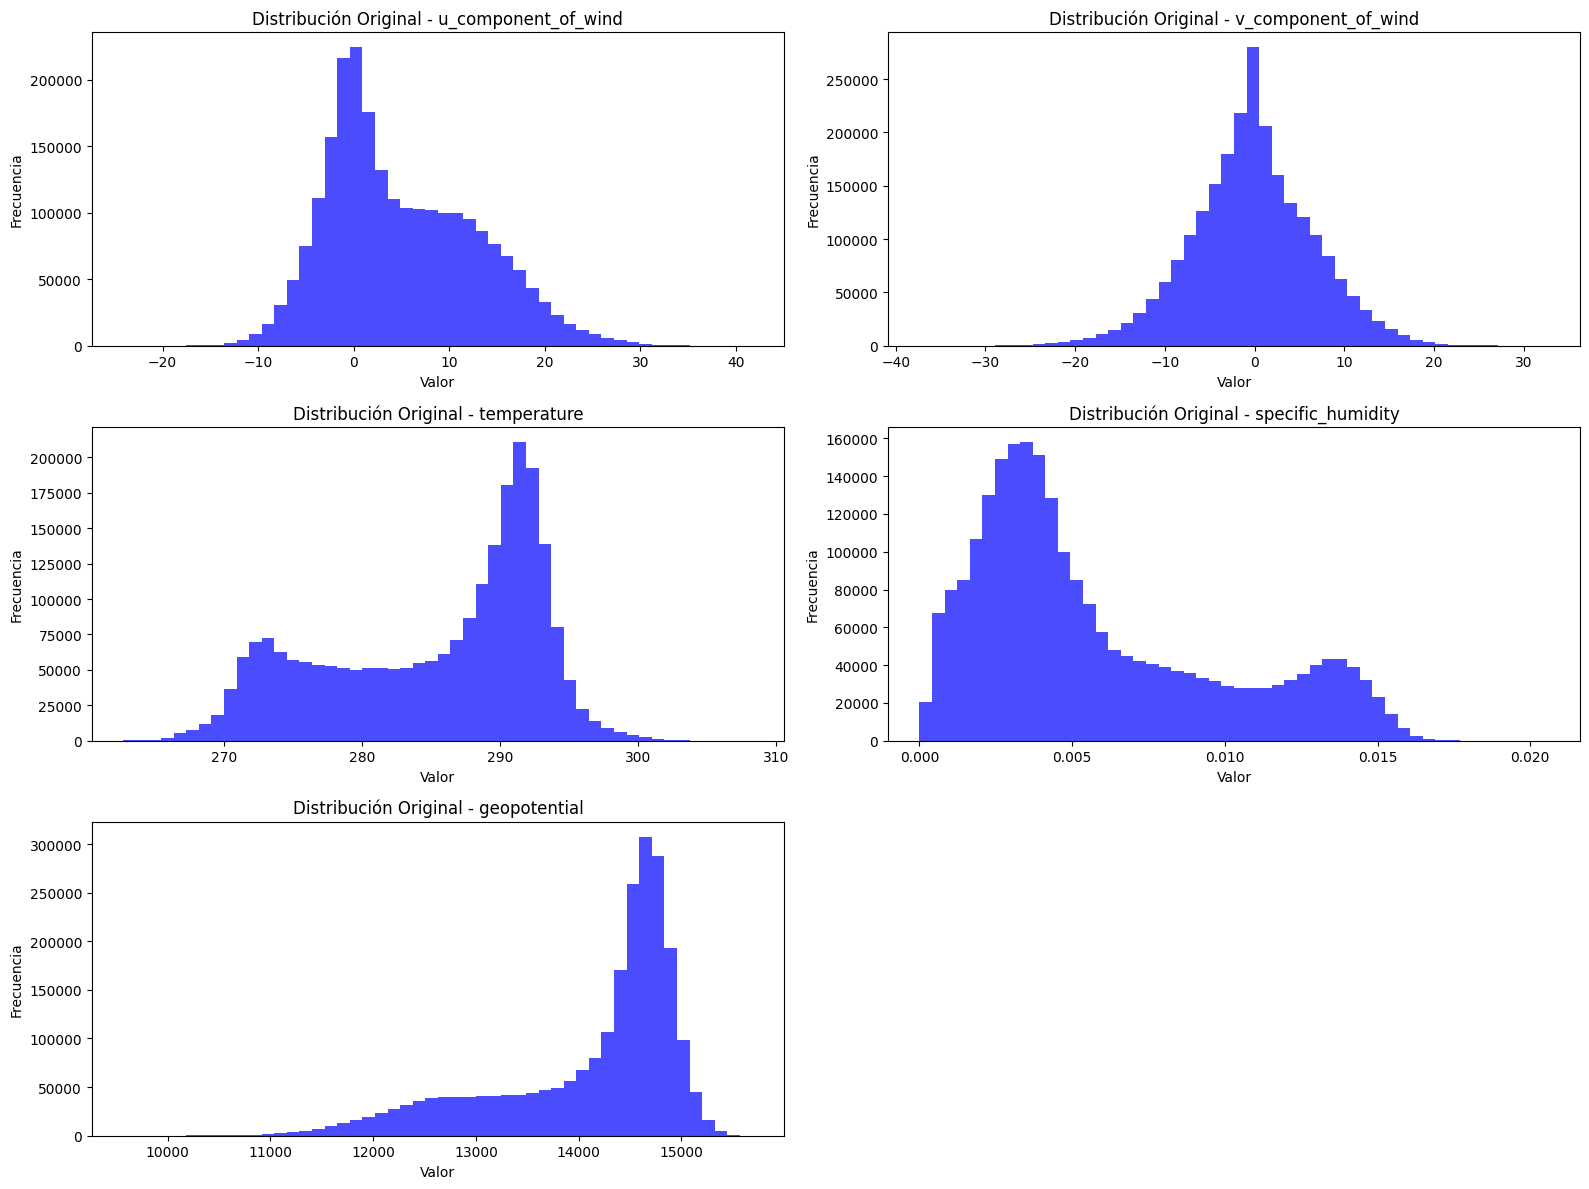

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12)) 
axes = axes.flatten()  
for i, var in enumerate(variables):
    axes[i].hist(ds[var].values.flatten(), bins=50, alpha=0.7, color="blue")
    axes[i].set_title(f'Distribución Original - {var}')
    axes[i].set_xlabel("Valor")
    axes[i].set_ylabel("Frecuencia")
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

#### 1.3 Preprocesamiento de datos

Se preprocesa el dataset según diferentes rangos de tiempo, se convierten en tensores y luego se calcula su media y dev estándar para poder normalizar las variables.

In [11]:
def preprocess_dataset(ds, variables, train_time_scale, val_time_scale, test_time_scale):
    train_vars = [ds[var].sel(time=train_time_scale).values for var in variables]  # Entrenamiento
    val_vars = [ds[var].sel(time=val_time_scale).values for var in variables]     # Validación
    test_vars = [ds[var].sel(time=test_time_scale).values for var in variables]   # Prueba

    train_data = np.array(train_vars)
    val_data = np.array(val_vars)
    test_data = np.array(test_vars)

    train_data = torch.tensor(train_data, dtype=torch.float32)
    val_data = torch.tensor(val_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)

    lat, lon = train_data.shape[2], train_data.shape[3]

    means = train_data.mean(dim=(1, 2, 3), keepdim=True)
    stds = train_data.std(dim=(1, 2, 3), keepdim=True)
    
    train_data = (train_data - means) / stds
    val_data = (val_data - means) / stds
    test_data = (test_data - means) / stds

    return train_data, val_data, test_data, lat, lon, means, stds

In [42]:
train_time_scale = slice("2010-01-01", "2010-01-20")
val_time_scale = slice("2010-01-21", "2010-01-25")
test_time_scale = slice("2010-01-26", "2010-01-31")

Se necesita reorganizar las dimensiones del tensor para que la dimensión temporal sea la primera, por ende se cambioa el orden de las dimensiones del tensor. pasando de [n_variables, n_times, latitud, longitud] a [n_times, n_variables, latitud, longitud].

In [44]:
train_data, val_data, test_data, lat, lon, means, stds = preprocess_dataset(
    ds, 
    variables, 
    train_time_scale, 
    val_time_scale, 
    test_time_scale
)

train_data = train_data.permute(1, 0, 2, 3)
val_data = val_data.permute(1, 0, 2, 3)
test_data = test_data.permute(1, 0, 2, 3)

print("Train Data Shape:", train_data.shape)
print("Validation Data Shape:", val_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: torch.Size([80, 5, 157, 121])
Validation Data Shape: torch.Size([20, 5, 157, 121])
Test Data Shape: torch.Size([24, 5, 157, 121])


Se crean divide la data en lotes de tamaño 8 y me mezcla el conjunto de prueba. 

In [45]:
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
test_dataset = TensorDataset(test_data)

batch_size = 8  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader:
    print("Train Batch Shape:", batch[0].shape)
    break

Train Batch Shape: torch.Size([8, 5, 157, 121])


#### 1.4 Definición de la red

Se crea un modelo convolucional simple para probar el conjunto de datos:

In [ ]:
class SimpleClimateModel(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SimpleClimateModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


Se define el bucle de entrenamiento para el modelo simple.

In [91]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=5, 
                physics_loss_fn=None, wind_components_fn=None):
    model.to(device)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_data = batch[0].to(device) 
            output = model(input_data)  
            
            if wind_components_fn and physics_loss_fn:
                u, v = wind_components_fn(input_data)
                dx, dy = 1, 1
                loss = physics_loss_fn(output, input_data, u, v, dx, dy)
            else:
                loss = loss_fn(output, input_data)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_data = batch[0].to(device)
                output = model(input_data)
                
                if wind_components_fn and physics_loss_fn:
                    u, v = wind_components_fn(input_data)
                    loss = physics_loss_fn(output, input_data, u, v, dx, dy)
                else:
                    loss = loss_fn(output, input_data)
                
                val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


### 2. Implementación del Modelo

#### 2.1 Implementación inicial

In [48]:
epochs = 100
input_channels = 5  
output_channels = 5 
model = SimpleClimateModel(input_channels, output_channels)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses_1, val_losses_1 = train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=epochs)

Epoch 1/100, Training Loss: 0.7069, Validation Loss: 0.3722
Epoch 2/100, Training Loss: 0.2556, Validation Loss: 0.1779
Epoch 3/100, Training Loss: 0.1599, Validation Loss: 0.1330
Epoch 4/100, Training Loss: 0.1090, Validation Loss: 0.0985
Epoch 5/100, Training Loss: 0.0775, Validation Loss: 0.0611
Epoch 6/100, Training Loss: 0.0518, Validation Loss: 0.0421
Epoch 7/100, Training Loss: 0.0364, Validation Loss: 0.0333
Epoch 8/100, Training Loss: 0.0282, Validation Loss: 0.0266
Epoch 9/100, Training Loss: 0.0236, Validation Loss: 0.0227
Epoch 10/100, Training Loss: 0.0206, Validation Loss: 0.0211
Epoch 11/100, Training Loss: 0.0188, Validation Loss: 0.0197
Epoch 12/100, Training Loss: 0.0174, Validation Loss: 0.0187
Epoch 13/100, Training Loss: 0.0164, Validation Loss: 0.0173
Epoch 14/100, Training Loss: 0.0155, Validation Loss: 0.0164
Epoch 15/100, Training Loss: 0.0147, Validation Loss: 0.0159
Epoch 16/100, Training Loss: 0.0141, Validation Loss: 0.0151
Epoch 17/100, Training Loss: 0.01

Gráfico de pérdida de train y validación

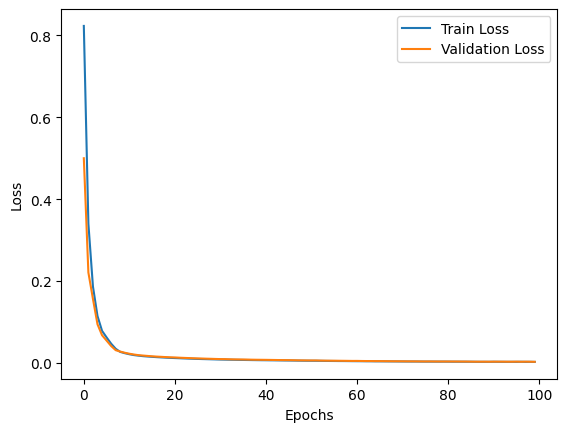

In [31]:
plt.plot(train_losses_1, label='Train Loss')
plt.plot(val_losses_1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Función para evaluar el modelo:

In [49]:
def evaluate_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_data = batch[0].to(device)
            output = model(input_data)
            loss = loss_fn(output, input_data)
            total_loss += loss.item()
    return total_loss / len(data_loader)


Evaluación del modelo contra conjunto test

In [50]:
test_loss = evaluate_model(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0030


Se calcula el MAE para evaluar la precisión del modelo. 

In [51]:
def mean_absolute_error(model, data_loader, device):
    model.eval()
    total_mae = 0
    with torch.no_grad():
        for batch in data_loader:
            input_data = batch[0].to(device)
            output = model(input_data)
            mae = torch.abs(output - input_data).mean().item()
            total_mae += mae
    return total_mae / len(data_loader)

test_mae = mean_absolute_error(model, test_loader, device)
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")


Mean Absolute Error (MAE): 0.0316


#### 2.2 Implementación con embeddings

Según Vaswani et al. (2017), es beneficioso implementar embeddings utilizando funciones trigonométricas como seno y coseno porque permiten representar posiciones de manera continua, periódica y sin ambigüedades. 


Un embedding es una representación numérica de datos en un espacio de menor dimensión, que preserva las relaciones y características importantes del conjunto original.

Se generan embeddings espaciales sobre lat y lon, a través de seno y coseno.

In [ ]:
def generate_spatial_embeddings(latitudes, longitudes):
    lat_rad = torch.tensor(np.radians(np.ravel(latitudes)), dtype=torch.float32) 
    lon_rad = torch.tensor(np.radians(np.ravel(longitudes)), dtype=torch.float32)

    sin_lat = torch.sin(lat_rad).unsqueeze(1).expand(-1, len(lon_rad)) 
    cos_lat = torch.cos(lat_rad).unsqueeze(1).expand(-1, len(lon_rad))
    sin_lon = torch.sin(lon_rad).unsqueeze(0).expand(len(lat_rad), -1)
    cos_lon = torch.cos(lon_rad).unsqueeze(0).expand(len(lat_rad), -1)

    spatial_embeddings = torch.stack([
        sin_lat * cos_lon, sin_lat * sin_lon,
        cos_lat * cos_lon, cos_lat * sin_lon
    ], dim=0)  # (4, lat, lon)

    return spatial_embeddings


In [ ]:
def generate_temporal_embeddings(time_steps):
    day_of_year = (time_steps.dayofyear / 365.0) * 2 * np.pi
    hour_of_day = (time_steps.hour / 24.0) * 2 * np.pi
    sin_day = torch.sin(torch.tensor(day_of_year, dtype=torch.float32)).unsqueeze(1)
    cos_day = torch.cos(torch.tensor(day_of_year, dtype=torch.float32)).unsqueeze(1)
    sin_hour = torch.sin(torch.tensor(hour_of_day, dtype=torch.float32)).unsqueeze(1)
    cos_hour = torch.cos(torch.tensor(hour_of_day, dtype=torch.float32)).unsqueeze(1) 
    temporal_embeddings = torch.cat([sin_day, cos_day, sin_hour, cos_hour], dim=1)  # Shape: (time, 4)
    return temporal_embeddings

In [56]:
latitudes = ds.latitude.values
longitudes = ds.longitude.values
spatial_embeddings = generate_spatial_embeddings(latitudes, longitudes)
print("Spatial Embeddings Shape:", spatial_embeddings.shape)

Spatial Embeddings Shape: torch.Size([4, 157, 121])


In [57]:
time_steps = ds.time.to_index()
temporal_embeddings = generate_temporal_embeddings(time_steps)
print("Temporal Embeddings Shape:", temporal_embeddings.shape) 

Temporal Embeddings Shape: torch.Size([124, 4])


Combinar data fisica con temp en un solo tensor

In [58]:
train_time_indices = range(len(train_data))
spatial_embeddings_expanded = spatial_embeddings.unsqueeze(0).expand(len(train_time_indices), -1, -1, -1) 
temporal_embeddings_expanded = temporal_embeddings[train_time_indices].unsqueeze(-1).unsqueeze(-1) 
temporal_embeddings_expanded = temporal_embeddings_expanded.expand(-1, -1, len(ds.latitude), len(ds.longitude))  
combined_data = torch.cat([train_data, spatial_embeddings_expanded, temporal_embeddings_expanded], dim=1)
print("Combined Data Shape:", combined_data.shape) 


Combined Data Shape: torch.Size([80, 13, 157, 121])


#### 2.3 Modelo nuevo con embeddings

Se genera nuevo modelo que acepta como entrada datos de embedding esp y temp. 

In [ ]:
class ClimateModelEmbeddings(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(ClimateModelEmbeddings, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

Se llevan los embedding con var climáticas a un tensor para train

In [60]:
combined_dataset = TensorDataset(combined_data)
combined_train_loader = DataLoader(combined_dataset, batch_size=8, shuffle=True)

Se combinan los embeddings con los datos climáticos de val

In [61]:
spatial_embeddings_val = spatial_embeddings.unsqueeze(0).expand(len(val_data), -1, -1, -1) 

temporal_embeddings_val = temporal_embeddings[:len(val_data)].unsqueeze(-1).unsqueeze(-1)  
temporal_embeddings_val = temporal_embeddings_val.expand(-1, -1, len(ds.latitude), len(ds.longitude))  

combined_val_data = torch.cat([val_data, spatial_embeddings_val, temporal_embeddings_val], dim=1) 

combined_val_dataset = TensorDataset(combined_val_data)
combined_val_loader = DataLoader(combined_val_dataset, batch_size=8, shuffle=False)


In [62]:
combined_val_data.shape

torch.Size([20, 13, 157, 121])

Se combinan los embeddings con var climáticas para prueba

In [ ]:
temporal_embeddings_test = temporal_embeddings[:len(test_data)].unsqueeze(-1).unsqueeze(-1)  # (24, 4, 1, 1)
temporal_embeddings_test = temporal_embeddings_test.expand(-1, -1, len(ds.latitude), len(ds.longitude))  # (24, 4, 157, 121)
spatial_embeddings_test = spatial_embeddings.unsqueeze(0).expand(len(test_data), -1, -1, -1)  # (24, 4, 157, 121)
combined_test_data = torch.cat([test_data, spatial_embeddings_test, temporal_embeddings_test], dim=1)  # (24, 13, 157, 121)
combined_test_dataset = TensorDataset(combined_test_data)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=8, shuffle=False)

In [82]:
combined_test_data.shape

torch.Size([24, 13, 157, 121])

Se pasan 13 input channel por 5 variables climáticas + 4 embeddings espaciales + 4 embeddings temporales

In [93]:
input_channels = 13 
output_channels = 13
model = ClimateModelEmbeddings(input_channels, output_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
model_with_embeddings = ClimateModelEmbeddings(input_channels, output_channels)
optimizer = torch.optim.Adam(model_with_embeddings.parameters(), lr=1e-3)
model.to(device)
train_losses, val_losses = train_model(
    model_with_embeddings, combined_train_loader, combined_val_loader, optimizer, loss_fn, device, epochs=100
)

Epoch 1/100, Training Loss: 0.3647, Validation Loss: 0.1926
Epoch 2/100, Training Loss: 0.1403, Validation Loss: 0.0963
Epoch 3/100, Training Loss: 0.0570, Validation Loss: 0.0463
Epoch 4/100, Training Loss: 0.0317, Validation Loss: 0.0270
Epoch 5/100, Training Loss: 0.0210, Validation Loss: 0.0229
Epoch 6/100, Training Loss: 0.0170, Validation Loss: 0.0183
Epoch 7/100, Training Loss: 0.0143, Validation Loss: 0.0175
Epoch 8/100, Training Loss: 0.0128, Validation Loss: 0.0157
Epoch 9/100, Training Loss: 0.0119, Validation Loss: 0.0139
Epoch 10/100, Training Loss: 0.0107, Validation Loss: 0.0121
Epoch 11/100, Training Loss: 0.0099, Validation Loss: 0.0119
Epoch 12/100, Training Loss: 0.0094, Validation Loss: 0.0109
Epoch 13/100, Training Loss: 0.0089, Validation Loss: 0.0107
Epoch 14/100, Training Loss: 0.0084, Validation Loss: 0.0103
Epoch 15/100, Training Loss: 0.0080, Validation Loss: 0.0103
Epoch 16/100, Training Loss: 0.0078, Validation Loss: 0.0088
Epoch 17/100, Training Loss: 0.00

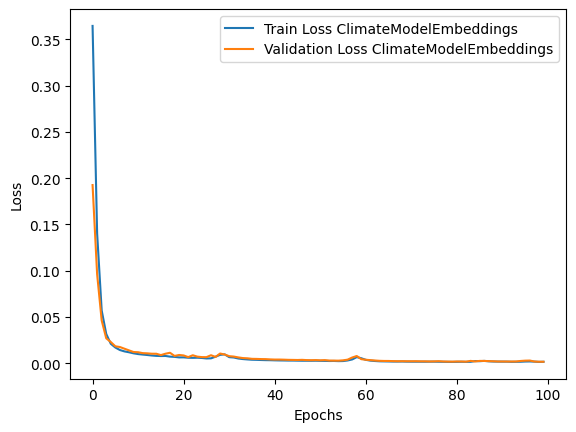

In [94]:
plt.plot(train_losses, label='Train Loss ClimateModelEmbeddings')
plt.plot(val_losses, label='Validation Loss ClimateModelEmbeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [95]:
test_loss = evaluate_model(model, combined_test_loader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.6174


In [96]:
test_mae = mean_absolute_error(model, combined_test_loader, device)
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")

Mean Absolute Error (MAE): 0.6049


#### 2.4 Implementación con PINN

calcular el gradiente en la dirección espacial

In [ ]:
def compute_gradient(x, dim):
    return torch.gradient(x, dim=dim)[0]

 función para restricciones físicas de advección

In [ ]:
def physics_loss(temperature, u, v, dx, dy):
    grad_T_x = compute_gradient(temperature, 3) 
    grad_T_y = compute_gradient(temperature, 2) 
    
    advection_x = u * grad_T_x
    advection_y = v * grad_T_y
    
    loss = torch.mean((advection_x + advection_y)**2) 
    return loss

sumar pérdida MSE con pérdida física

In [ ]:
def combined_loss(output, input_data, u, v, dx, dy):
    data_loss = nn.MSELoss()(output, input_data) 
    pde_loss = physics_loss(output, u, v, dx, dy) 
    return data_loss + pde_loss

obtener datos de u y v del tensor de entrada

In [ ]:
def get_wind_components(input_data):
    u = input_data[:, 3, :, :].unsqueeze(1) 
    v = input_data[:, 4, :, :].unsqueeze(1)
    return u, v

In [97]:
input_channels = 13
output_channels = 13
model = ClimateModelEmbeddings(input_channels, output_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses, val_losses = train_model(
    model=model,
    train_loader=combined_train_loader,
    val_loader=combined_val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    epochs=100,
    physics_loss_fn=combined_loss,      
    wind_components_fn=get_wind_components
)

Epoch 1/100, Training Loss: 0.3976, Validation Loss: 0.2154
Epoch 2/100, Training Loss: 0.1518, Validation Loss: 0.1058
Epoch 3/100, Training Loss: 0.0749, Validation Loss: 0.0625
Epoch 4/100, Training Loss: 0.0485, Validation Loss: 0.0455
Epoch 5/100, Training Loss: 0.0348, Validation Loss: 0.0352
Epoch 6/100, Training Loss: 0.0269, Validation Loss: 0.0312
Epoch 7/100, Training Loss: 0.0233, Validation Loss: 0.0285
Epoch 8/100, Training Loss: 0.0210, Validation Loss: 0.0255
Epoch 9/100, Training Loss: 0.0193, Validation Loss: 0.0238
Epoch 10/100, Training Loss: 0.0180, Validation Loss: 0.0230
Epoch 11/100, Training Loss: 0.0170, Validation Loss: 0.0213
Epoch 12/100, Training Loss: 0.0162, Validation Loss: 0.0203
Epoch 13/100, Training Loss: 0.0156, Validation Loss: 0.0191
Epoch 14/100, Training Loss: 0.0149, Validation Loss: 0.0196
Epoch 15/100, Training Loss: 0.0142, Validation Loss: 0.0195
Epoch 16/100, Training Loss: 0.0137, Validation Loss: 0.0190
Epoch 17/100, Training Loss: 0.01

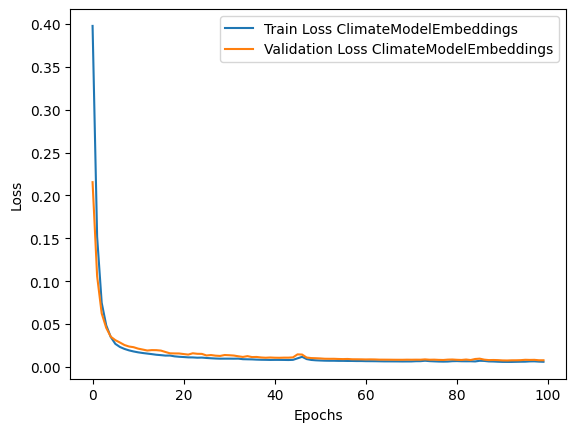

In [98]:
plt.plot(train_losses, label='Train Loss ClimateModelEmbeddings')
plt.plot(val_losses, label='Validation Loss ClimateModelEmbeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [100]:
test_mae = mean_absolute_error(model, combined_test_loader, device)
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")

Mean Absolute Error (MAE): 0.0319


Evaluación con MSE Loss

In [99]:
test_loss = evaluate_model(model, combined_test_loader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0026


Evaluación con pérdida física

In [101]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in combined_test_loader:
        input_data = batch[0].to(device) 
        output = model(input_data) 
        u, v = get_wind_components(input_data)
        dx, dy = 1, 1
        loss = combined_loss(output, input_data, u, v, dx, dy)
        test_loss += loss.item()
avg_test_loss = test_loss / len(combined_test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.0070


Reconstrucción del modelo

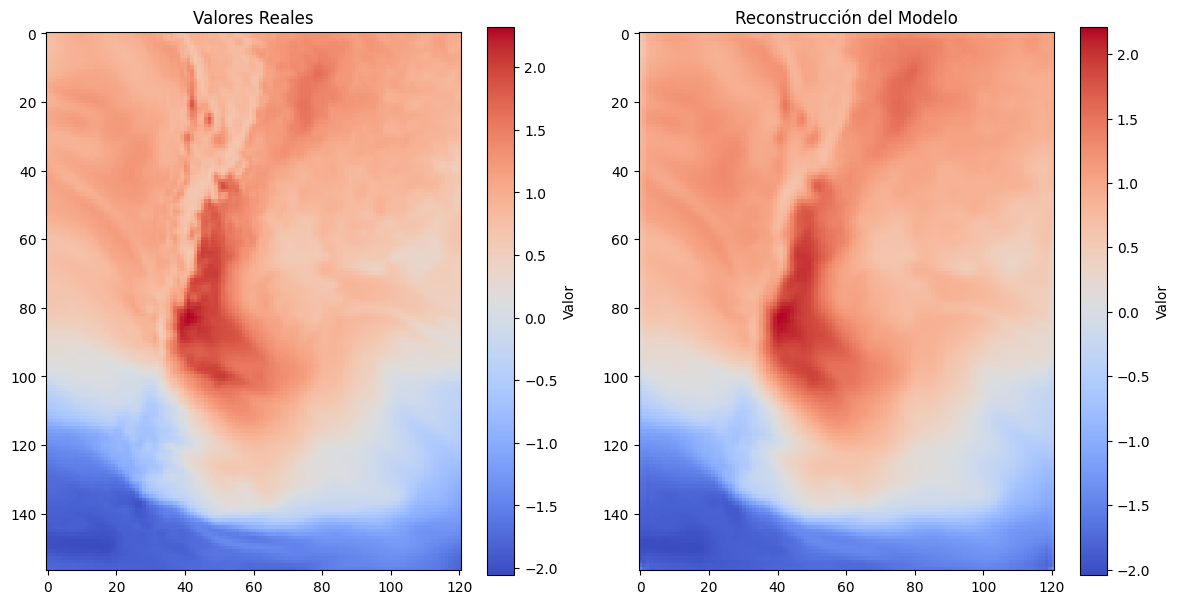

In [103]:
batch = next(iter(combined_test_loader))
input_data = batch[0].to(device) 
output = model(input_data).detach().cpu() 
variable_index = 2
real_data = input_data[:, variable_index, :, :].cpu().numpy() 
predicted_data = output[:, variable_index, :, :].numpy()
time_step = 0 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Valores Reales")
plt.imshow(real_data[time_step], cmap="coolwarm")
plt.colorbar(label="Valor")

plt.subplot(1, 2, 2)
plt.title("Reconstrucción del Modelo")
plt.imshow(predicted_data[time_step], cmap="coolwarm")
plt.colorbar(label="Valor")

plt.tight_layout()
plt.show()

### 3. Modelo Predictivo 

#### 3.1 Dataset para predicción

Se crea un dataset de predicción a fin de transformar data secuencial de forma de q el modelo pueda aprender a mapear el pasado (48 días después):

In [124]:
def create_prediction_dataset(data, lags=1):
    X = []
    y = []
    for t in range(lags, len(data)):
        X.append(data[t-lags:t])  
        y.append(data[t])        
    X = torch.stack(X) 
    y = torch.stack(y)
    return X, y

lags = 2
train_X, train_y = create_prediction_dataset(train_data, lags)
val_X, val_y = create_prediction_dataset(val_data, lags)
test_X, test_y = create_prediction_dataset(test_data, lags)

print("Train Input Shape:", train_X.shape)  
print("Train Target Shape:", train_y.shape)


Train Input Shape: torch.Size([78, 2, 5, 157, 121])
Train Target Shape: torch.Size([78, 5, 157, 121])


#### 3.2 Modelo

Se crea nuevo modelo de datos considerando lags ahora en él:

In [ ]:
class ClimatePredictionModel(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(ClimatePredictionModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = torch.mean(x, dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


#### 3.3 Ciclo de entrenamiento

In [208]:
def evaluate_model_metrics(model, data_loader, loss_fn, device, physics_loss_fn=None, wind_components_fn=None, dx=1, dy=1):
    model.eval()
    total_loss = 0
    total_mae = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)            
            output = model(X_batch)
            if physics_loss_fn and wind_components_fn:
                u, v = wind_components_fn(X_batch)
                loss = physics_loss_fn(output, y_batch, u, v, dx, dy)
            else:
                loss = loss_fn(output, y_batch)
            
            total_loss += loss.item()
            mae = torch.abs(output - y_batch).mean().item()
            total_mae += mae

    avg_loss = total_loss / len(data_loader)
    avg_mae = total_mae / len(data_loader)
    return avg_loss, avg_mae


In [125]:
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [131]:
def train_model_predictive(model, train_loader, val_loader, optimizer, loss_fn, device, 
                                   physics_loss_fn=None, wind_components_fn=None, dx=1, dy=1, epochs=50):
    model.to(device)
    train_losses = []
    val_losses = []
    val_maes = []

    for epoch in range(epochs):

        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            
            if physics_loss_fn and wind_components_fn:
                u, v = wind_components_fn(X_batch)
                loss = physics_loss_fn(output, y_batch, u, v, dx, dy)
            else:
                loss = loss_fn(output, y_batch)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        mae = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                
                if physics_loss_fn and wind_components_fn:
                    u, v = wind_components_fn(X_batch)
                    loss = physics_loss_fn(output, y_batch, u, v, dx, dy)
                else:
                    loss = loss_fn(output, y_batch)
                
                val_loss += loss.item()
                mae += torch.abs(output - y_batch).mean().item()

        val_losses.append(val_loss / len(val_loader))
        val_maes.append(mae / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val MAE: {val_maes[-1]:.4f}")

    return train_losses, val_losses, val_maes


In [200]:
epochs = 50
model = ClimatePredictionModel(input_channels=5, output_channels=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses, val_losses, val_maes = train_model_predictive(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    epochs=epochs
)


Epoch 1/50, Train Loss: 0.6148, Val Loss: 0.3750, Val MAE: 0.4620
Epoch 2/50, Train Loss: 0.2972, Val Loss: 0.2962, Val MAE: 0.3904
Epoch 3/50, Train Loss: 0.2455, Val Loss: 0.2670, Val MAE: 0.3585
Epoch 4/50, Train Loss: 0.2206, Val Loss: 0.2486, Val MAE: 0.3403
Epoch 5/50, Train Loss: 0.2067, Val Loss: 0.2496, Val MAE: 0.3415
Epoch 6/50, Train Loss: 0.2013, Val Loss: 0.2333, Val MAE: 0.3274
Epoch 7/50, Train Loss: 0.1953, Val Loss: 0.2340, Val MAE: 0.3294
Epoch 8/50, Train Loss: 0.1897, Val Loss: 0.2234, Val MAE: 0.3191
Epoch 9/50, Train Loss: 0.1852, Val Loss: 0.2207, Val MAE: 0.3171
Epoch 10/50, Train Loss: 0.1825, Val Loss: 0.2153, Val MAE: 0.3147
Epoch 11/50, Train Loss: 0.1817, Val Loss: 0.2197, Val MAE: 0.3190
Epoch 12/50, Train Loss: 0.1802, Val Loss: 0.2146, Val MAE: 0.3140
Epoch 13/50, Train Loss: 0.1801, Val Loss: 0.2165, Val MAE: 0.3197
Epoch 14/50, Train Loss: 0.1796, Val Loss: 0.2167, Val MAE: 0.3169
Epoch 15/50, Train Loss: 0.1784, Val Loss: 0.2141, Val MAE: 0.3146
Epoc

In [209]:
test_loss, test_mae = evaluate_model_metrics(
    model=model, 
    data_loader=test_loader, 
    loss_fn=nn.MSELoss(), 
    device=device
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 0.2155
Test MAE: 0.3184


In [129]:
def get_wind_components_pred(input_data):
    u = input_data[:, :, 3, :, :].mean(dim=1, keepdim=True)
    v = input_data[:, :, 4, :, :].mean(dim=1, keepdim=True)
    
    return u, v


In [210]:
model_2 = ClimatePredictionModel(input_channels=5, output_channels=5)
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses_2, val_losses_2, val_maes_2 = train_model_predictive(
    model=model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    physics_loss_fn=combined_loss,       
    wind_components_fn=get_wind_components_pred,  
    dx=1, dy=1,
    epochs=50
)


Epoch 1/50, Train Loss: 0.5803, Val Loss: 0.3894, Val MAE: 0.4431
Epoch 2/50, Train Loss: 0.3001, Val Loss: 0.2862, Val MAE: 0.3658
Epoch 3/50, Train Loss: 0.2403, Val Loss: 0.2635, Val MAE: 0.3480
Epoch 4/50, Train Loss: 0.2201, Val Loss: 0.2514, Val MAE: 0.3390
Epoch 5/50, Train Loss: 0.2081, Val Loss: 0.2422, Val MAE: 0.3300
Epoch 6/50, Train Loss: 0.2033, Val Loss: 0.2381, Val MAE: 0.3260
Epoch 7/50, Train Loss: 0.1984, Val Loss: 0.2284, Val MAE: 0.3211
Epoch 8/50, Train Loss: 0.1973, Val Loss: 0.2293, Val MAE: 0.3230
Epoch 9/50, Train Loss: 0.1925, Val Loss: 0.2303, Val MAE: 0.3193
Epoch 10/50, Train Loss: 0.1892, Val Loss: 0.2291, Val MAE: 0.3198
Epoch 11/50, Train Loss: 0.1872, Val Loss: 0.2235, Val MAE: 0.3145
Epoch 12/50, Train Loss: 0.1886, Val Loss: 0.2181, Val MAE: 0.3124
Epoch 13/50, Train Loss: 0.1853, Val Loss: 0.2237, Val MAE: 0.3138
Epoch 14/50, Train Loss: 0.1871, Val Loss: 0.2219, Val MAE: 0.3140
Epoch 15/50, Train Loss: 0.1828, Val Loss: 0.2213, Val MAE: 0.3150
Epoc

In [211]:
test_loss, test_mae = evaluate_model_metrics(
    model=model_2, 
    data_loader=test_loader, 
    loss_fn=nn.MSELoss(), 
    device=device
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 0.2053
Test MAE: 0.3133


Creamos un modelo con y sin batch norm para probar su efecto:

In [213]:
class ClimatePredictionModelV2(nn.Module):
    def __init__(self, input_channels, output_channels, dropout_rate=0.2):
        super(ClimatePredictionModelV2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)        
        self.bn1 = nn.BatchNorm2d(64) 
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)        
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        x = torch.mean(x, dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.conv4(x)
        return x

In [ ]:
class ClimatePredictionModelV3(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(ClimatePredictionModelV3, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.mean(x, dim=1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

In [214]:
model_3 = ClimatePredictionModelV2(input_channels=5, output_channels=5, dropout_rate=0)
optimizer = torch.optim.Adam(model_3.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses_3, val_losses_3, val_maes_3 = train_model_predictive(
    model=model_3,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    physics_loss_fn=combined_loss,       
    wind_components_fn=get_wind_components_pred,  
    dx=1, dy=1,
    epochs=50
)


Epoch 1/50, Train Loss: 0.4049, Val Loss: 0.3754, Val MAE: 0.4742
Epoch 2/50, Train Loss: 0.2289, Val Loss: 0.2786, Val MAE: 0.3733
Epoch 3/50, Train Loss: 0.2105, Val Loss: 0.2513, Val MAE: 0.3534
Epoch 4/50, Train Loss: 0.1931, Val Loss: 0.2281, Val MAE: 0.3278
Epoch 5/50, Train Loss: 0.2057, Val Loss: 0.2416, Val MAE: 0.3336
Epoch 6/50, Train Loss: 0.2366, Val Loss: 0.2579, Val MAE: 0.3559
Epoch 7/50, Train Loss: 0.2034, Val Loss: 0.2415, Val MAE: 0.3366
Epoch 8/50, Train Loss: 0.1951, Val Loss: 0.2184, Val MAE: 0.3217
Epoch 9/50, Train Loss: 0.2007, Val Loss: 0.2358, Val MAE: 0.3429
Epoch 10/50, Train Loss: 0.1951, Val Loss: 0.2344, Val MAE: 0.3427
Epoch 11/50, Train Loss: 0.1880, Val Loss: 0.2192, Val MAE: 0.3201
Epoch 12/50, Train Loss: 0.1817, Val Loss: 0.2387, Val MAE: 0.3441
Epoch 13/50, Train Loss: 0.1822, Val Loss: 0.2380, Val MAE: 0.3464
Epoch 14/50, Train Loss: 0.1771, Val Loss: 0.2094, Val MAE: 0.3106
Epoch 15/50, Train Loss: 0.1764, Val Loss: 0.2060, Val MAE: 0.3134
Epoc

In [215]:
test_loss, test_mae = evaluate_model_metrics(
    model=model_3, 
    data_loader=test_loader, 
    loss_fn=nn.MSELoss(), 
    device=device
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 0.1942
Test MAE: 0.3074


In [219]:
model_4 = ClimatePredictionModelV3(input_channels=5, output_channels=5)
optimizer = torch.optim.Adam(model_4.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses_4, val_losses_4, val_maes_4 = train_model_predictive(
    model=model_4,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    physics_loss_fn=combined_loss,       
    wind_components_fn=get_wind_components_pred,  
    dx=1, dy=1,
    epochs=50
)


Epoch 1/50, Train Loss: 0.4668, Val Loss: 0.2922, Val MAE: 0.3824
Epoch 2/50, Train Loss: 0.2412, Val Loss: 0.2467, Val MAE: 0.3360
Epoch 3/50, Train Loss: 0.2151, Val Loss: 0.2400, Val MAE: 0.3326
Epoch 4/50, Train Loss: 0.2029, Val Loss: 0.2461, Val MAE: 0.3296
Epoch 5/50, Train Loss: 0.2022, Val Loss: 0.2252, Val MAE: 0.3178
Epoch 6/50, Train Loss: 0.1930, Val Loss: 0.2241, Val MAE: 0.3227
Epoch 7/50, Train Loss: 0.1881, Val Loss: 0.2228, Val MAE: 0.3176
Epoch 8/50, Train Loss: 0.1864, Val Loss: 0.2178, Val MAE: 0.3156
Epoch 9/50, Train Loss: 0.1775, Val Loss: 0.2163, Val MAE: 0.3110
Epoch 10/50, Train Loss: 0.1770, Val Loss: 0.2357, Val MAE: 0.3324
Epoch 11/50, Train Loss: 0.1797, Val Loss: 0.2325, Val MAE: 0.3240
Epoch 12/50, Train Loss: 0.1785, Val Loss: 0.2212, Val MAE: 0.3157
Epoch 13/50, Train Loss: 0.1728, Val Loss: 0.2128, Val MAE: 0.3089
Epoch 14/50, Train Loss: 0.1742, Val Loss: 0.2187, Val MAE: 0.3163
Epoch 15/50, Train Loss: 0.1720, Val Loss: 0.2168, Val MAE: 0.3147
Epoc

In [220]:
test_loss, test_mae = evaluate_model_metrics(
    model=model_4, 
    data_loader=test_loader, 
    loss_fn=nn.MSELoss(), 
    device=device
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 0.1940
Test MAE: 0.2996


#### 3.4 Evaluación

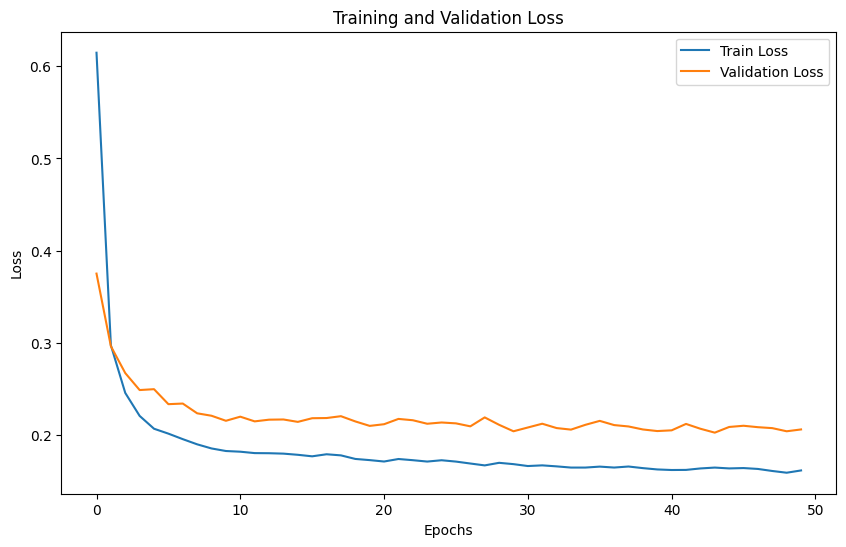

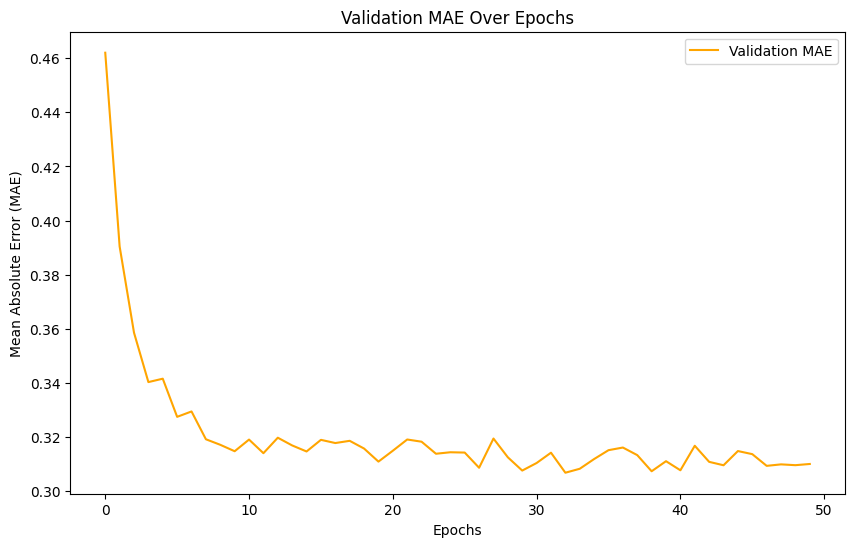

In [221]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_maes, label="Validation MAE", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Validation MAE Over Epochs")
plt.legend()
plt.show()

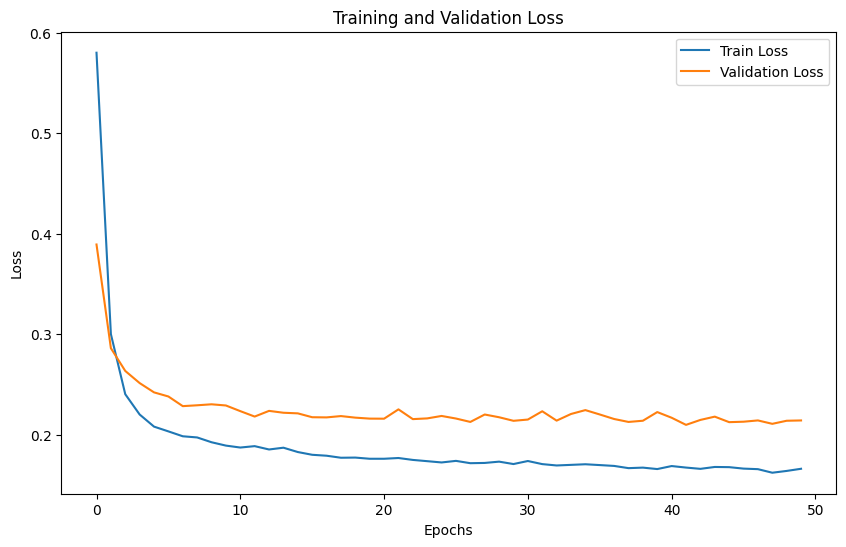

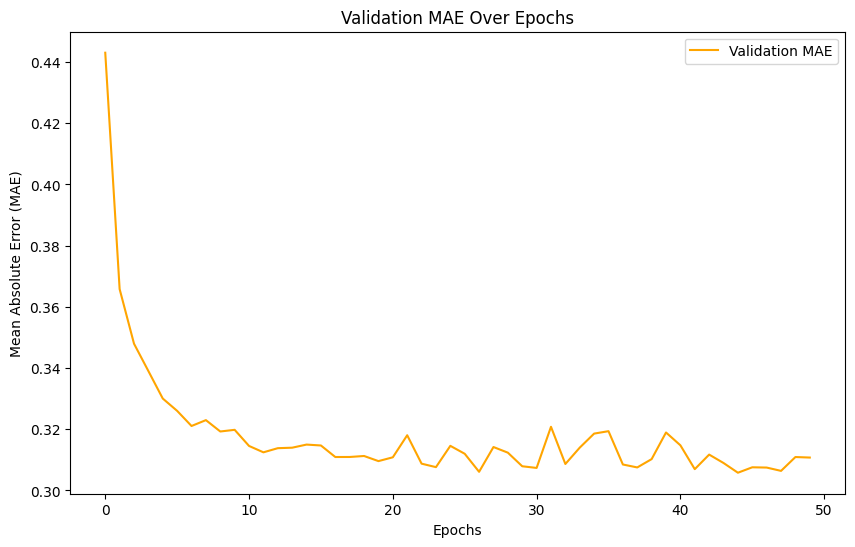

In [222]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label="Train Loss")
plt.plot(val_losses_2, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_maes_2, label="Validation MAE", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Validation MAE Over Epochs")
plt.legend()
plt.show()

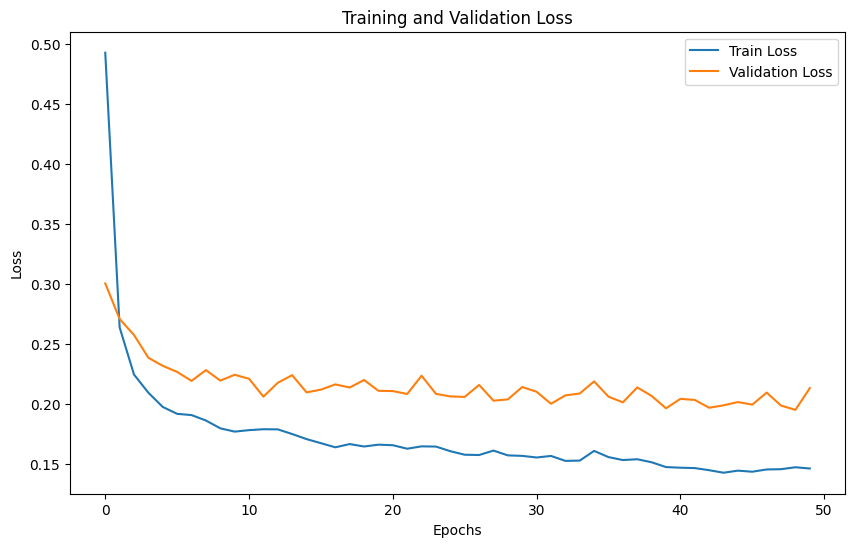

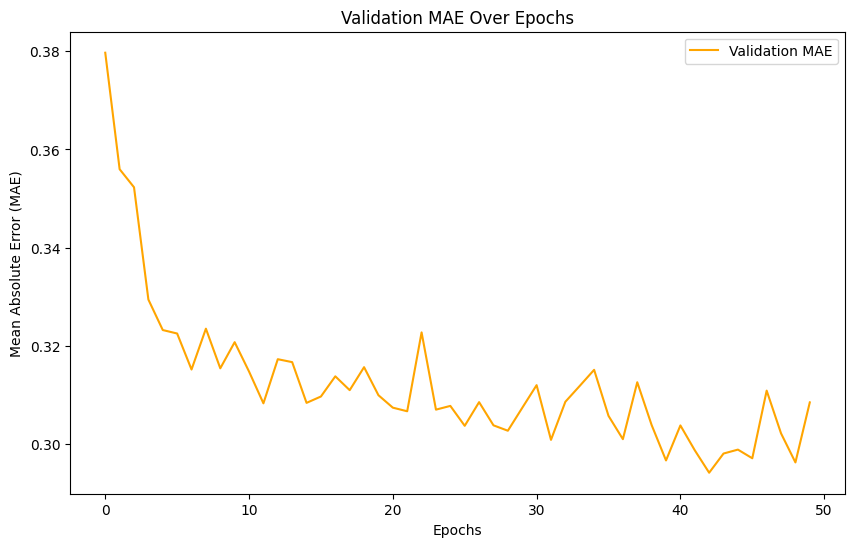

In [223]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_3, label="Train Loss")
plt.plot(val_losses_3, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_maes_3, label="Validation MAE", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Validation MAE Over Epochs")
plt.legend()
plt.show()

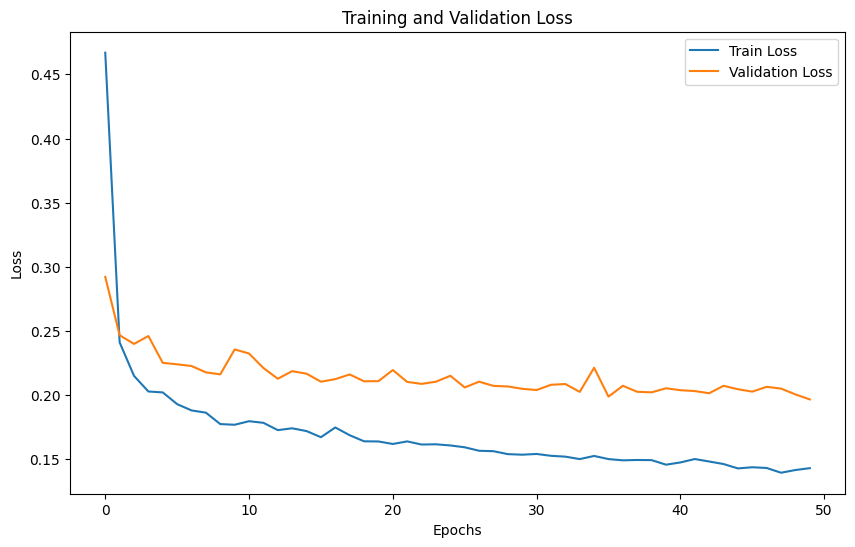

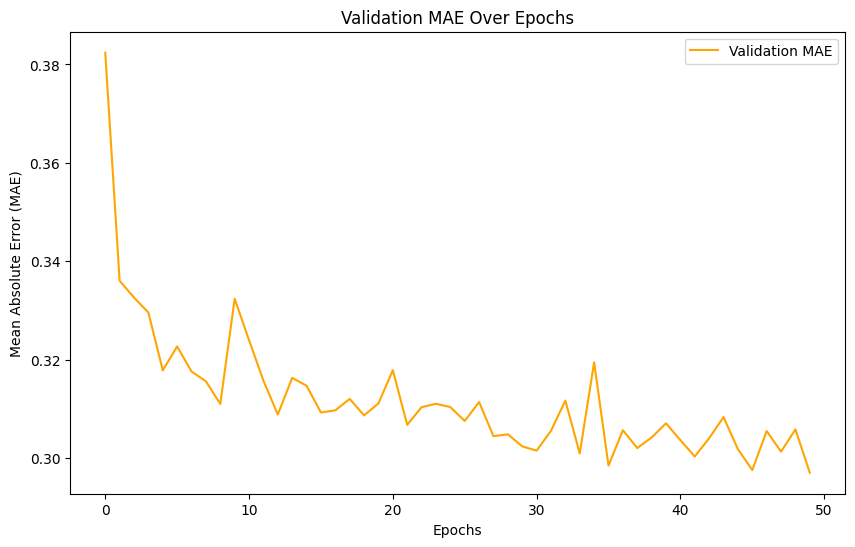

In [224]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_4, label="Train Loss")
plt.plot(val_losses_4, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_maes_4, label="Validation MAE", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Validation MAE Over Epochs")
plt.legend()
plt.show()

#### 3.5 Visualización de una predicción

A continuación se pueden evaluar las diferencias visuales entre la predicción y los datos reales:

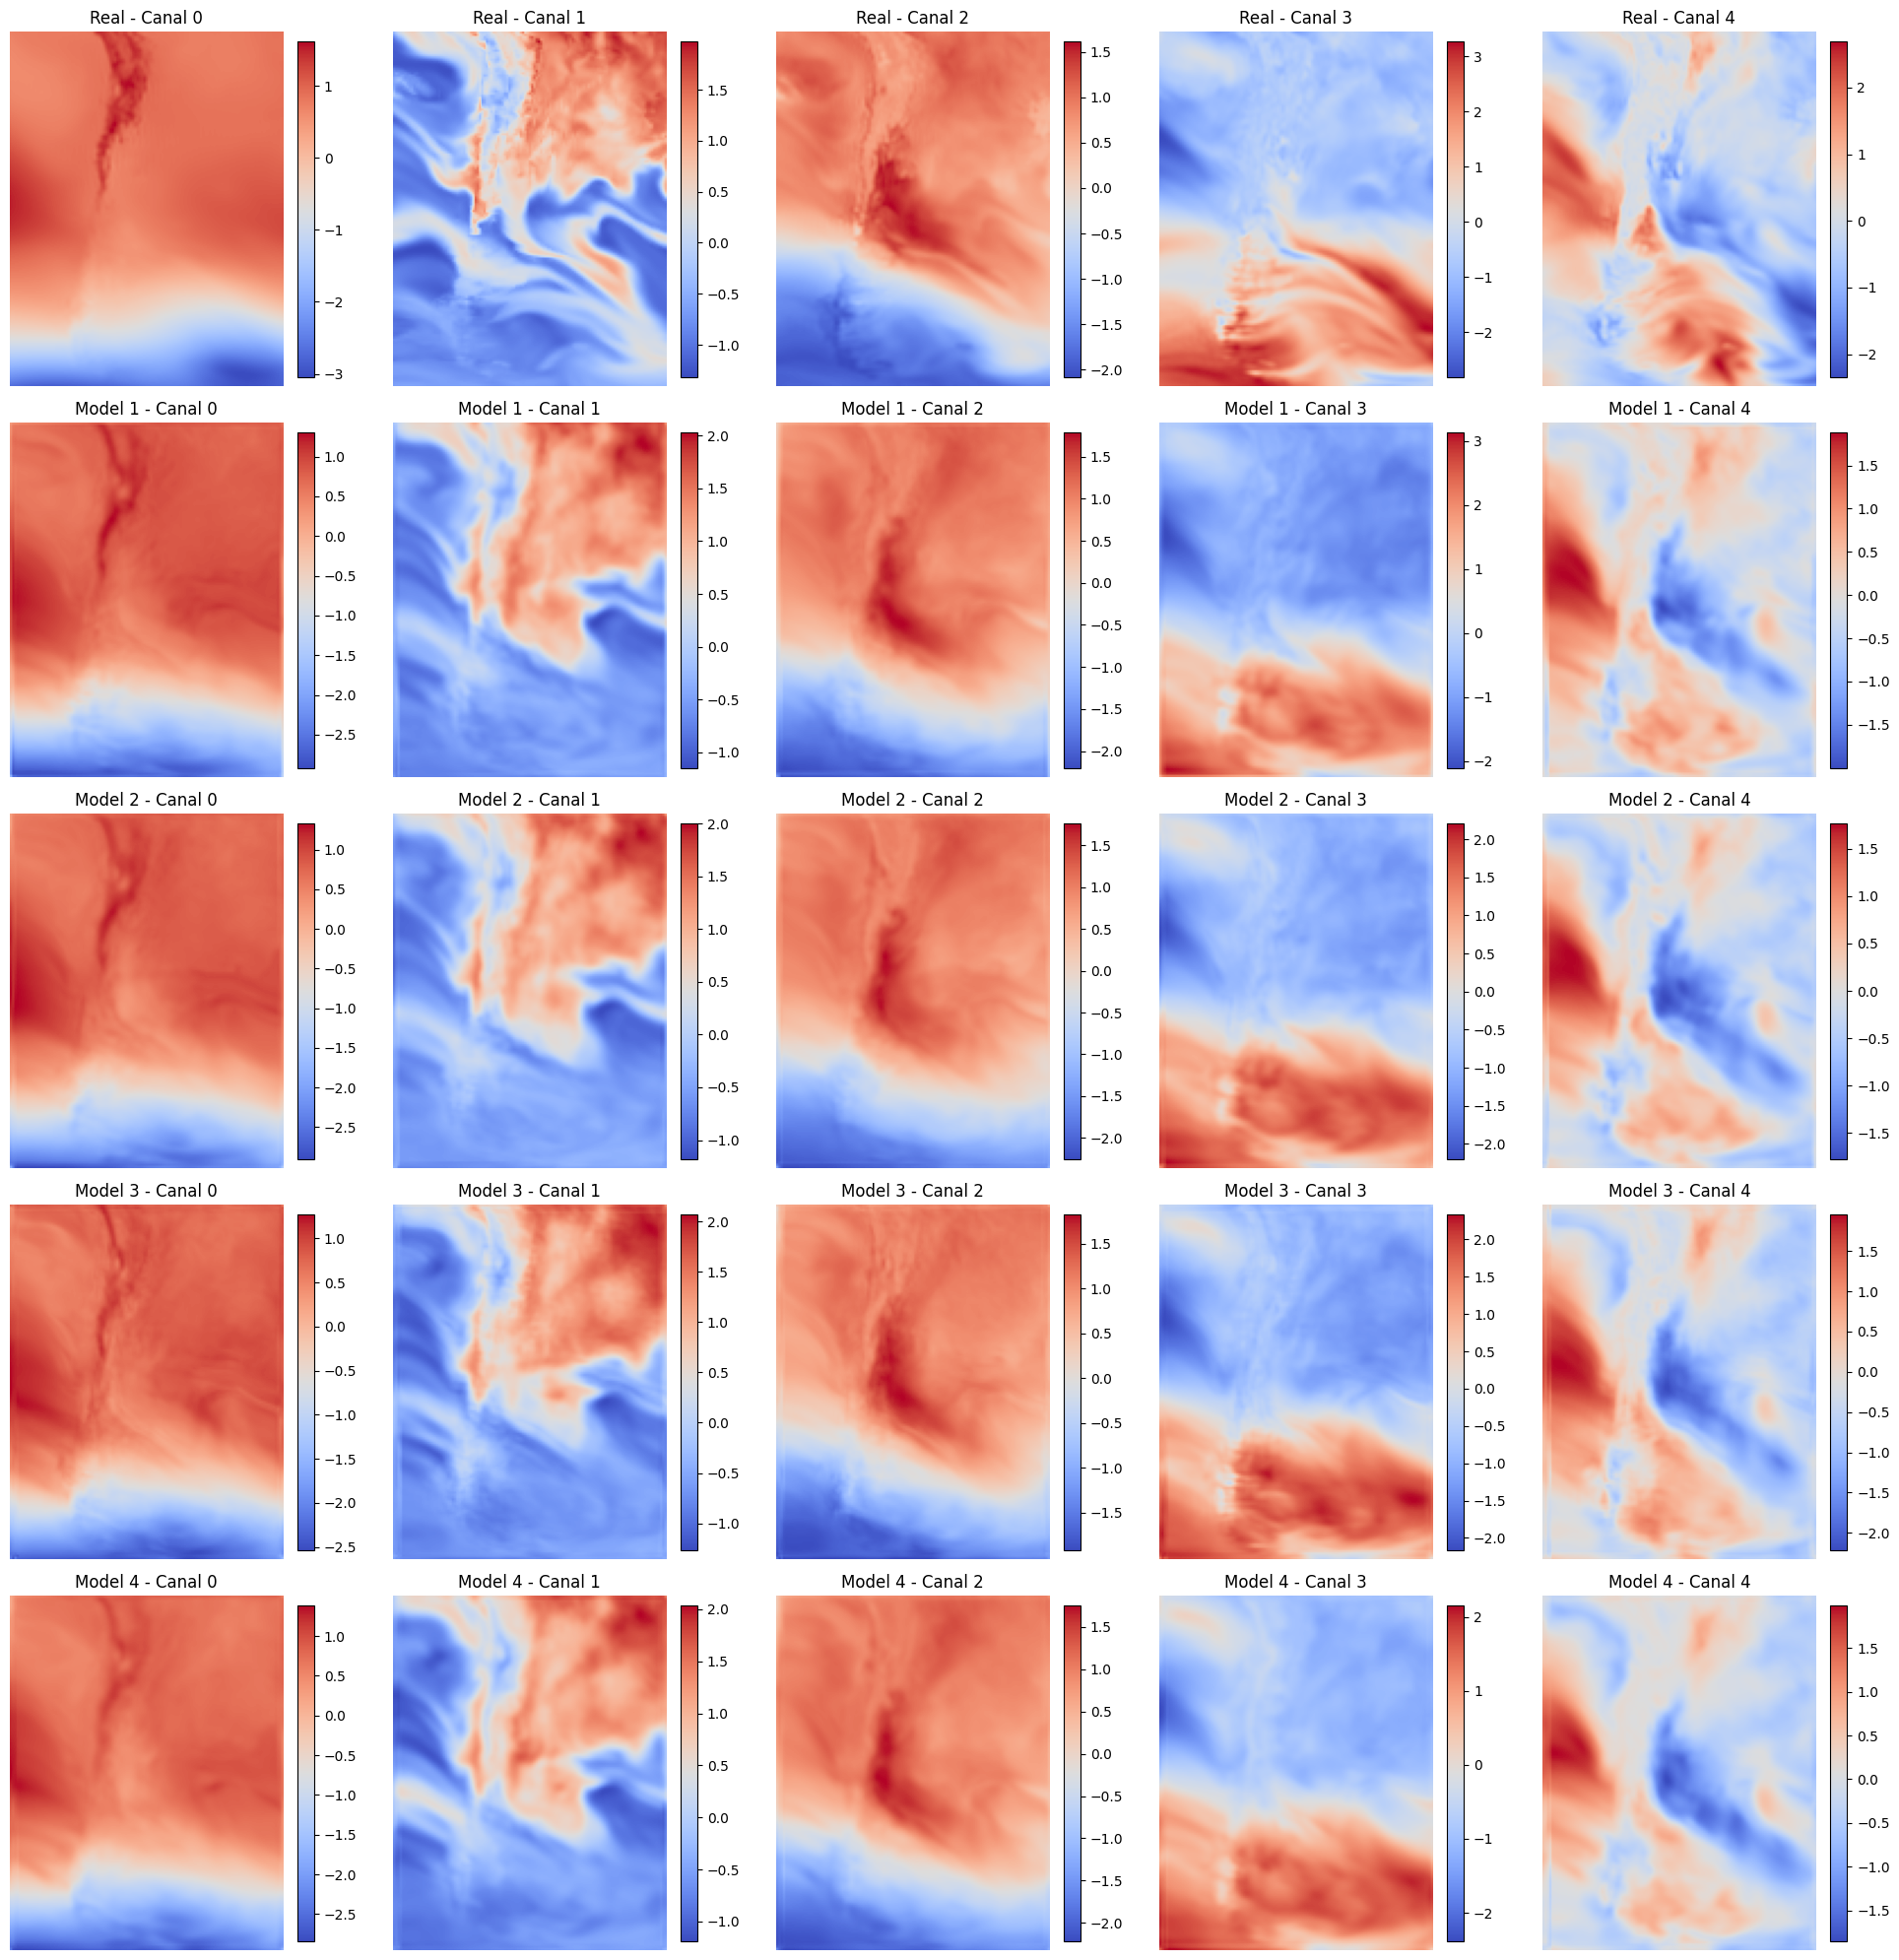

In [227]:
models = {
    "Model 1": model,
    "Model 2": model_2,
    "Model 3": model_3,
    "Model 4": model_4
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for X_batch, y_batch in test_loader: 
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = {name: model.to(device)(X_batch) for name, model in models.items()}
        break
num_channels = y_batch.shape[1]
time_step = 0 
n_models = len(models) + 1 
fig, axes = plt.subplots(n_models, num_channels, figsize=(4 * num_channels, 4 * n_models))

for channel in range(num_channels):
    real_data = y_batch[time_step, channel].cpu().numpy()
    ax_real = axes[0, channel]
    im_real = ax_real.imshow(real_data, cmap="coolwarm")
    ax_real.set_title(f"Real - Canal {channel}")
    ax_real.axis("off")
    plt.colorbar(im_real, ax=ax_real, fraction=0.046, pad=0.04)

for row, (name, preds) in enumerate(predictions.items(), start=1):
    for channel in range(num_channels):
        predicted_data = preds[time_step, channel].cpu().numpy()
        ax_pred = axes[row, channel]
        im_pred = ax_pred.imshow(predicted_data, cmap="coolwarm")
        ax_pred.set_title(f"{name} - Canal {channel}")
        ax_pred.axis("off")
        plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()